Synchronization
===============

In this tutorial we will demonstrate how to synchronize two Qblox instruments using the SYNQ technology (see section 
[Synchronization](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/synchronization.html)).
For this tutorial we will use one Pulsar QCM and one Pulsar QRM and we will be acquiring waveforms sequenced by the Pulsar QCM using the Pulsar QRM. 
By synchronizing the two instruments using the SYNQ technology, timing the acquisition of the waveforms becomes trivial.

For this tutorial to work, we need to connect both instruments to the same network, connect the $\text{REF}^{out}$ of the Pulsar QCM to the 
$\text{REF}^{in}$ of the Pulsar QRM using a 50cm coaxial cable, connect their SYNQ ports using the SYNQ cable and finally connect $\text{O}^{[1-2]}$ of the Pulsar QCM to $\text{I}^{[1-2]}$ of the Pulsar QRM respectively.

This tutorial is designed with the Pulsar QCM as output instrument in mind, but the Pulsar QCM can easily be swapped with another Pulsar QRM as well. 
Just change the Pulsar QCM instantiation to a Pulsar QRM instantiation.

Setup
-----

First, we are going to import the required packages and connect to the instruments.

In [1]:
#Set up the environment.
import pprint
import os
import scipy.signal
import math
import json
import matplotlib.pyplot
import numpy

from pulsar_qcm.pulsar_qcm import pulsar_qcm
from pulsar_qrm.pulsar_qrm import pulsar_qrm

#Close any existing connections to any pulsar module
pulsar_qcm.close_all()
pulsar_qrm.close_all()

#Connect to the Pulsar QCM at default IP address.
pulsar_qcm = pulsar_qcm("qcm", "192.168.0.2")

#Reset the Pulsar QCM for good measure.
pulsar_qcm.reset()
print("QCM status:")
print(pulsar_qcm.get_system_status())
print()

#Connect to the Pulsar QRM at alternate address.
pulsar_qrm = pulsar_qrm("qrm", "192.168.0.3")

#Reset the Pulsar QRM for good measure.
pulsar_qrm.reset()
print("QRM status:")
print(pulsar_qrm.get_system_status())

QCM status:
{'status': 'OKAY', 'flags': []}

QRM status:
{'status': 'OKAY', 'flags': []}


We also need to configure the reference clock sources of the instruments. The Pulsar QCM is used as the overal reference source and needs to
be configured to use its internal reference clock (the default setting). The Pulsar QRM will use the Pulsar QCM's reference clock and needs to be
configured to use the external reference clock source.

In [2]:
#Set reference clock source.
pulsar_qrm.reference_source("external")

Generate waveforms
------------------

Next, we need to create the waveforms for the sequence.

In [3]:
#Waveform parameters
waveform_length = 120 #nanoseconds
    
#Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
                "gaussian": {"data": [], "index": 0},
                "sine":     {"data": [], "index": 1}
            }

#Create gaussian waveform
if "gaussian" in waveforms:
    waveforms["gaussian"]["data"] = scipy.signal.gaussian(waveform_length, std=0.12 * waveform_length)

#Create sine waveform
if "sine" in waveforms:
    waveforms["sine"]["data"] = [math.sin((2*math.pi/waveform_length)*i) for i in range(0, waveform_length)]

Let's plot the waveforms to see what we have created.

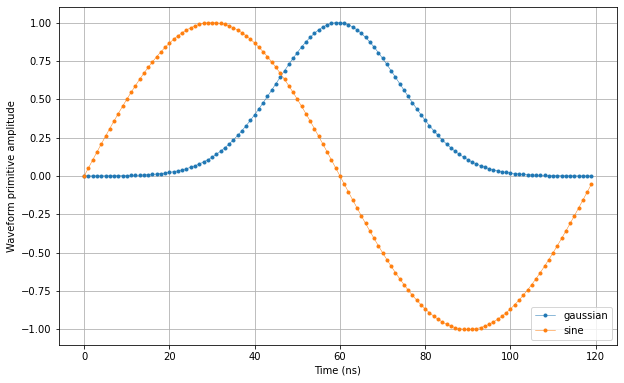

In [4]:
time    = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1,1, figsize=(10, 10/1.61))

ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

for wf, d in waveforms.items():
    ax.plot(time[:len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()

matplotlib.pyplot.draw()
matplotlib.pyplot.show()   # add this at EOF to prevent execution stall

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for it's acquisition list. In this case we will create one acquisition specification that creates a single bin. However, we will not be using the bin in this turorial.

In [5]:
#Acquisitions
acquisitions = {"measurement":  {"num_bins": 1,
                                 "index": 0}}

Create Q1ASM programs
---------------------

Now that we have the waveforms for the sequence, we need a simple Q1ASM program that sequences the waveforms in the Pulsar QCM and
acquires the waveforms in the Pulsar QRM.

In [6]:
#Pulsar QCM sequence program.
qcm_seq_prog = """
wait_sync 4         #Synchronize sequencers over multiple instruments.
play      0,1,16384 #Play waveforms and wait remaining duration of scope acquisition.
stop                #Stop.
"""

#Pulsar QRM sequence program.
qrm_seq_prog = """
wait_sync 4         #Synchronize sequencers over multiple instruments.
acquire   0,0,16384 #Acquire waveforms and wait remaining duration of scope acquisition.
stop                #Stop.
"""

Upload sequences
----------------

Now that we have the waveforms and Q1ASM programs, we can combine them in the sequences stored in JSON files.

In [7]:
#Reformat waveforms to lists if necessary.
for name in waveforms:
    if str(type(waveforms[name]["data"]).__name__) == "ndarray":
        waveforms[name]["data"] = waveforms[name]["data"].tolist()  # JSON only supports lists

#Add QCM sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": waveforms, "weights": {}, "acquisitions": acquisitions, "program": qcm_seq_prog}
with open("qcm_sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

#Add QRM sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": waveforms, "weights": {}, "acquisitions": acquisitions, "program": qrm_seq_prog}
with open("qrm_sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 of both the Pulsar QCM and Pulsar QCM, which will drive outputs $\text{O}^{[1-2]}$
of the Pulsar QCM and acquire on inputs $\text{I}^{[1-2]}$ of the Pulsar QRM.

In [8]:
#Upload waveforms and programs to Pulsar QCM.
pulsar_qcm.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "qcm_sequence.json"))

#Upload waveforms and programs to Pulsar QRM.
pulsar_qrm.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "qrm_sequence.json"))

Play sequences
--------------

The sequence has been uploaded to the instruments. Now we need to configure the sequencers of both the Pulsar QCM and Pulsar QRM to use the `wait_sync` instruction
to synchronize and we need to configure the sequencer of the Pulsar QRM to trigger the acquisition with the `acquire` instruction.
Furthermore we also need to attenuate the Pulsar QCM's outputs to 40% to be able to capture the full range of the waveforms on the Pulsar QRM's inputs.

$\text{Attenuation}={Input}/{Output}={2V}/{5V}={0.4}$

In [9]:
#Configure the sequencer of the Pulsar QCM.
pulsar_qcm.sequencer0_sync_en(True)
pulsar_qcm.sequencer0_gain_awg_path0(0.35) #Adding a bit of margin to the 0.4
pulsar_qcm.sequencer0_gain_awg_path1(0.35)

#Map sequencer of the Pulsar QCM to specific outputs (but first disable all sequencer connections)
for sequencer in range(0, 6):
    for out in range(0, 2):
        pulsar_qcm.set("sequencer{}_channel_map_path{}_out{}_en".format(sequencer, out%2, out), False)
pulsar_qcm.sequencer0_channel_map_path0_out0_en(True)
pulsar_qcm.sequencer0_channel_map_path1_out1_en(True)

#Configure the scope acquisition of the Pulsar QRM.
pulsar_qrm.scope_acq_sequencer_select(0)
pulsar_qrm.scope_acq_trigger_mode_path0("sequencer")
pulsar_qrm.scope_acq_trigger_mode_path1("sequencer")

#Configure the sequencer of the Pulsar QRM.
pulsar_qrm.sequencer0_sync_en(True)

Now let's start the sequences.

In [10]:
#Arm and start sequencer of the Pulsar QCM (only sequencer 0).
pulsar_qcm.arm_sequencer(0)
pulsar_qcm.start_sequencer()

#Print status of sequencer of the Pulsar QCM.
print("QCM status:")
print(pulsar_qcm.get_sequencer_state(0))
print()

#Arm and start sequencer of the Pulsar QRM (only sequencer 0).
pulsar_qrm.arm_sequencer(0)
pulsar_qrm.start_sequencer()

#Print status of sequencer of the Pulsar QRM.
print("QRM status:")
print(pulsar_qrm.get_sequencer_state(0))

QCM status:
{'status': 'Q1 STOPPED', 'flags': []}

QRM status:
{'status': 'STOPPED', 'flags': ['ACQ SCOPE DONE PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ BINNING DONE']}


Retrieve acquisition
--------------------

The waveforms have now been sequenced on the outputs and acquired on the inputs by both instruments. And as you might have noticed, timing these operations was simplified
significantly by the SYNQ technology. Lets retrieve the resulting data, but first let's make sure the sequencers have finished.

In [11]:
#Wait for the sequencers to stop with a timeout period of one minute.
pulsar_qcm.get_sequencer_state(0, 1)
pulsar_qrm.get_sequencer_state(0, 1)

#Wait for the acquisition to finish with a timeout period of one minute.
pulsar_qrm.get_acquisition_state(0, 1)

#Move acquisition data from temporary memory to acquisition list.
pulsar_qrm.store_scope_acquisition(0, "measurement")

#Get acquisition list from instrument.
acq = pulsar_qrm.get_acquisitions(0)

Let's plot the result.

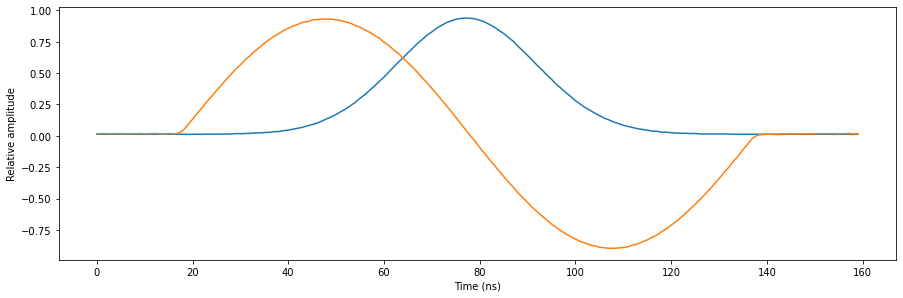

In [12]:
#Plot acquired signal on both inputs.
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15/2/1.61))
ax.plot(acq["measurement"]["acquisition"]["scope"]["path0"]["data"][130:290])
ax.plot(acq["measurement"]["acquisition"]["scope"]["path1"]["data"][130:290])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Relative amplitude')
matplotlib.pyplot.show()

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connections.

In [13]:
#Stop sequencers.
pulsar_qcm.stop_sequencer()
pulsar_qrm.stop_sequencer()

#Print status of sequencers.
print("QCM status:")
print(pulsar_qcm.get_sequencer_state(0))
print()

print("QRM status:")
print(pulsar_qrm.get_sequencer_state(0))
print()

#Print an overview of instrument parameters.
print("QCM snapshot:")
pulsar_qcm.print_readable_snapshot(update=True)
print()

print("QRM snapshot:")
pulsar_qrm.print_readable_snapshot(update=True)

#Close the instrument connections.
pulsar_qcm.close()
pulsar_qrm.close()

QCM status:
{'status': 'STOPPED', 'flags': ['FORCED STOP']}

QRM status:
{'status': 'STOPPED', 'flags': ['FORCED STOP', 'ACQ SCOPE DONE PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ BINNING DONE']}

QCM snapshot:
qcm:
	parameter                                  value
--------------------------------------------------------------------------------
IDN                                         :	{'manufacturer': 'Qblox', 'mode...
out0_offset                                 :	0 (V)
out1_offset                                 :	0 (V)
out2_offset                                 :	0 (V)
out3_offset                                 :	0 (V)
reference_source                            :	internal 
sequencer0_channel_map_path0_out0_en        :	True 
sequencer0_channel_map_path0_out2_en        :	True 
sequencer0_channel_map_path1_out1_en        :	True 
sequencer0_channel_map_path1_out3_en        :	True 
sequencer0_cont_mode_en_awg_path0           :	False 
sequencer0_cont_mode_en_awg_path1           :	False 